# TP 5 - Compression d'images par K-means et centres mobiles


Dans cet exercice, on cherche à réduire le nombre de couleur d’une image pour la compresser.

### Données

Les données relatives à cet exercice sont à télécharger sur le cours Eureka sous forme d’un fichier compacté zip `Données de l’exercice sur le clustering`.

Il contient notamment un fichier image tiff de 538×538 pixels nommé `bird_large.tiff` :

![image bird_large](images/bird_large.png)

Cette image est au format 24-bits avec des couleurs codées en RVB (RGB en angais), correspondant à la combinaison de l'intensitée de 3 couleurs de base : rouge, vert et bleu. L'intensité pour chacune de ces couleurs varie entre 0 et 255, nécessitant 1 octet (i.e. 8-bits), soit 16 millions de couleurs possibles.

L’objectif est de réduire ce nombre de couleurs utilisées dans l'image à seulement 16 couleurs et donc de compresser l’image.

On va utiliser pour cela un algorithme K-means. On va calculer 16 couleurs correspondant au centre de centroïds. Et on va remplacer la couleur de chaque pixel par la couleur du centroïd qui en est la plus proche.

Pour réduire le temps de calcul du à la manipulation de l'image au format 538x538 pixels, on va déterminer ces clusters de couleurs en utilisant une image plus petite : `bird_small.tiff` au format 128×128 pixels. Ensuite, on appliquera cette définition des couleurs sur la grande image.

On peut charger l’image par le code :

    import matplotlib.image as mpimg
    import numpy as np
    img = mpimg.imread("bird_small.tiff")

`img` est alors une matrice à 3 dimensions contenant la position du pixel pour les deux premiers indices, et la valeur de la composante couleur indiquée par le troisième indice. Par exemple, `img[50, 33, 2]` donnera l'intensité de la troisième composante de couleur (bleu) du pixel à la position (50,33).

On peut modifier la couleur du pixel de coordonnées (100,120) de la manière suivante :

    img[100, 120] = (56, 120, 355)
    
La couleur de ce pixel sera codée par (rouge=56, vert=120, bleu=355).

Le but est d’identifier 16 centroids de clusters à partir de l'image. A chaque centroïd $j$, une couleur est associé et correspond à un vecteur à 3 composantes selon le codage RVB :  
$\mu_j = [r_j,v_j,b_j]$.

Ci-dessous, on désigne par $x_i= [r_i,v_i,b_i]$, le vecteur couleur à 3 composantes RVB pour chaque pixel $i$ de l’image. Ainsi x est stockée sous la forme d’une matrice à 3 colonnes (une pour chaque composante) et à 128×128 lignes si l’on prend la petite image.

De même, $\mu$ peut être vue comme une matrice de 16 lignes et 3 colonnes.

NB : on peut cependant continuer de fonctionner avec les coordonnées des pixels dans la matrice (fonctionner avec un indice de ligne, un indice de colonne), il faudra adapter l’algorithme ci-dessous.

### Algorithme K-means

1. Commencer par choisir aléatoirement 16 couleurs dans l’image pour caractériser les centroids initiaux, les k-means : $\mu_1, \mu_2, \dots, \mu_k$.

2. Pour chacun des pixels $i$ dans l’image, trouver la valeur de couleur la plus proche parmis les $\mu_j$ et enregister l'indice du centroïd correspondant :

$$
c_i = \arg\min_j \parallel x_i − \mu_j \parallel ^2
$$

3. Mettre à jour les couleurs $\mu_j$ associées à chacun des 16 centroids connaissant les pixels constituant les clusters (on recalcule la moyenne des couleurs des pixels qui appartiennent au même centroïde avec une formule de barycentre equipondéré) :
$$
\mu_j(j) = \frac{\sum_i 1\{c_i = j\}x_i}{\sum_i 1\{c_i = j\}}
$$
où $1\{\dots\}$ désigne la fonction indicatrice qui vaut 1 lorsque l'expression booléenne dans l'accolade est vraie et 0 sinon.

4. Répéter les étapes 2 et 3 jusqu’à la convergence (entre 30 et 100 itérations). Deux possibilités : soit fixer le nombre d’itérations au départ de la boucle, soit entrer dans une boucle de laquelle on sort dès que les couleurs associées aux centroids sont stabilisées.

NB 1 : commencer par un nombre fixe d’itérations avant de mettre au point la seconde alternative.

NB 2 : à l’étape 3, il est possible qu’un centroid ne possède aucun pixel, on risque alors une division par 0 ce qu’il faut détecter pour éviter cette situation.

### Application à la grande image

Après la convergence de l’étape précédente, prendre la grande image et remplacer la couleur de chaque pixel par la couleur du centroïd la plus proche et calculée sur la petite image. Puis afficher l’image obtenue avec un code du type :

    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.show()

Forme des centroïdes : (16, 3)
Les 16 couleurs initiales (RGB) :
[[101. 101.  95.]
 [222. 185. 113.]
 [175. 112.  41.]
 [254. 250. 217.]
 [247. 236. 173.]
 [ 21.  21.  20.]
 [217. 180. 155.]
 [ 54.  51.  58.]
 [ 13.  14.  11.]
 [125. 113.  78.]
 [ 83.  83. 150.]
 [ 33.  41.  26.]
 [201. 167.  91.]
 [ 67.  53.  43.]
 [130. 107. 113.]
 [135.  99.  33.]]
Convergence atteinte à l'itération 80 !
Dimensions originales : 538x538 pixels


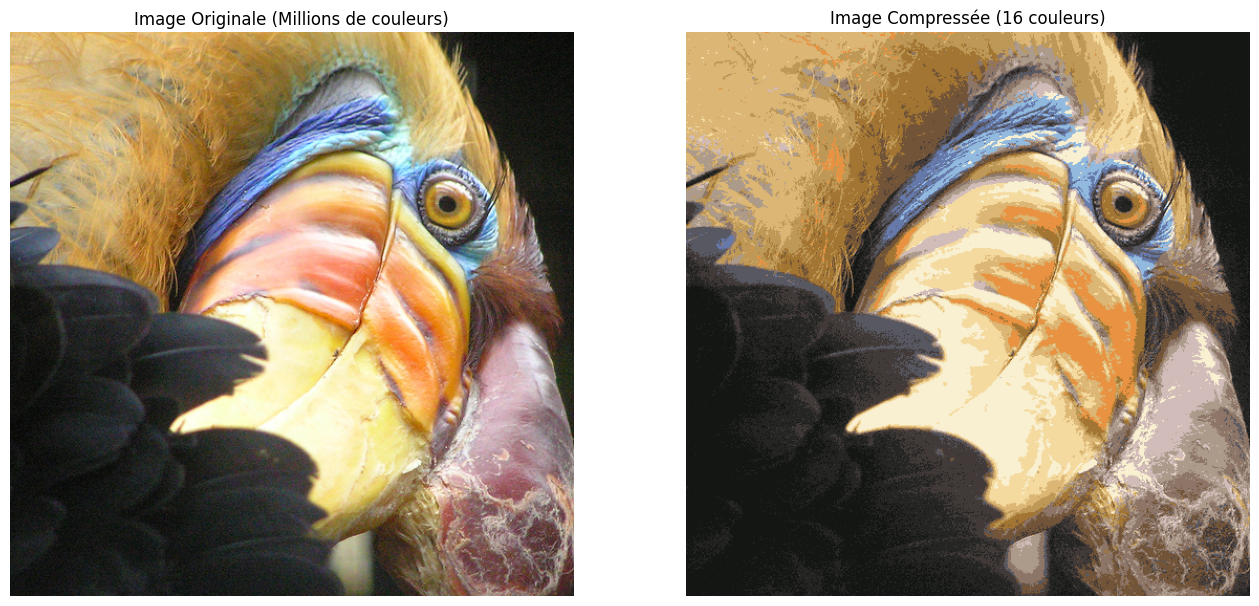

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("bird_small.tiff")
k = 16

# Transformation de l'image en une matrice de pixels (N lignes, 3 colonnes)
# On aplatit la hauteur et la largeur pour avoir une simple liste de tous les pixels
X = img.reshape(-1, 3).astype(float)
# On choisie 16 indices parmi tout les pixels disponibles
# replace=False assure qu'on ne choisit pas deux fois le même pixel
indices_aleatoires = np.random.choice(X.shape[0], size=k, replace=False)

# On récupére les couleurs correspondantes (les centroïdes initiaux)
mu = X[indices_aleatoires]

print("Forme des centroïdes :", mu.shape)
print("Les 16 couleurs initiales (RGB) :")
print(mu)

# Fonction qui stocke pour chaque pixels l'indice de la couleur la plus proche pour les 16 centroids
def trouve_plus_proche_centroide(X, mu):
  """
    Arguments:
    X : Matrice (N, 3) contenant tous les pixels de l'image
    mu : Matrice (K, 3) contenant les 16 couleurs actuelles des centres

    Retourne:
    idx : Vecteur (N,) contenant l'index (0 à 15) du cluster le plus proche pour chaque pixel
    """
  # Calcule des distances
  # Nous voulons calculer la distance pour chaque pixels la plus proche parmi les centroides
  # On étend les dimensions pour pouvoir soustraire les matrices :
  # pixels[:, np.newaxis] devient (N, 1, 3)
  # centroids devient (1, K, 3)
  # La soustraction crée une matrice géante (N, K, 3)
  diff = X[:, np.newaxis] - mu

  # On met au carré et on somme sur les couleurs (axis=2) pour avoir la distance euclidienne
  distances = np.sum(diff**2,axis=2)

  # Selection du plus proche

  # Pour chaque pixels, on cherche l'indice de la valeur minimale
  idx = np.argmin(distances,axis=1)

  return idx

#idx = trouve_plus_proche_centroide(X, mu)
#print("Indices des clusters :", idx)
#print("Taille des indices :", idx.shape)

# Etape 3 : calculer le centre de gravité

# Fonction qui calcule la valeur de la couleur moyenne pour mettre a jour mu de j
def calcul_centre_gravite(X, idx, k):
    # On initialise le tableau pour les nouv centres
    new_centres = np.zeros((k, 3))

    for j in range(k):
        pixels_du_cluster = X[idx == j]

        if len(pixels_du_cluster) > 0:
            new_centres[j] = np.mean(pixels_du_cluster, axis=0)
        else:
            # Si le cluster est vide, on garde l'ancienne position pour ne pas le perdre
            # C'est mieux que de laisser à 0 (noir)
            new_centres[j] = mu[j]
            print(f"Le cluster {j} est vide ! (Position conservée)")

    return new_centres


for i in range(100):
    mu_old = mu.copy()
    idx = trouve_plus_proche_centroide(X, mu)
    mu = calcul_centre_gravite(X, idx, k)
    # Test de stabilité (Convergence)
    # Si la différence entre les nouveaux et les anciens est nulle (ou très petite)
    if np.allclose(mu, mu_old):
        print(f"Convergence atteinte à l'itération {i} !")
        break # On sort de la boucle immédiatement

# Charger la GRANDE image
# Assurez-vous que le fichier est au bon endroit
img_large = mpimg.imread("bird_large.tiff")

# On sauvegarde les dimensions d'origine (538 x 538) pour la reconstruction plus tard
h, w, c = img_large.shape
print(f"Dimensions originales : {h}x{w} pixels")

#  Préparer les données (Reshape)
# Comme pour la petite image, on transforme la grille en une longue liste de pixels
X_large = img_large.reshape(-1, 3).astype(float)
# 3. Assignation des couleurs (L'étape clé)
# On n'entraîne plus l'algorithme ! On utilise juste les 'mu' calculés sur la petite image.
# Pour chaque pixel de la grande image, on trouve l'indice (0-15) de la couleur la plus proche.
idx_large = trouve_plus_proche_centroide(X_large, mu)

#  Remplacement des couleurs (Compression)
# Cette ligne remplace chaque pixel par la couleur de son centroïde
# X_recovered sera la liste des pixels compressés
X_recovered = mu[idx_large]

# 5. Reconstruction de l'image (Reshape inverse)
# On remet la longue liste sous forme de carré (538x538x3)
img_compressed = X_recovered.reshape(h, w, c)

# Création d'une figure plus large pour accueillir les deux images
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# --- Image 1 : L'originale (à gauche) ---
ax[0].imshow(img_large.astype('uint8'))
ax[0].set_title("Image Originale (Millions de couleurs)")
ax[0].axis('off') # On cache les axes

# --- Image 2 : La version compressée (à droite) ---
ax[1].imshow(img_compressed.astype('uint8'))
ax[1].set_title(f"Image Compressée ({len(mu)} couleurs)")
ax[1].axis('off')

# Affichage final
plt.show()